In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
def Dispersion(data):
  mean = data.mean()
  D = 0
  for i in data:
    D += (i - mean)**2
  D = D/(len(data)-1)
  return D
def standartdeviation(data):
  return sqrt(Dispersion(data))
def range1(data):
  return data.max() - data.min()
def cv(data):
  return standartdeviation(data)/data.mean()
def standarterror(data):
  return standartdeviation(data)/data.shape[0]
def countall(data):
  di = {'data': [Dispersion(data), standartdeviation(data), data.mean(), data.median(), cv(data), range1(data)],
        'name': ['dispersion', 'standart deviation', 'mean', 'median', 'cv', 'range']}
  df = pd.DataFrame(di)
  return df
def countall_dict(data):
  di = {'dispersion': Dispersion(data),
        'standart deviation': standartdeviation(data),
        'mean': data.mean(),
        'median': data.median(),
        'STD(cv)': cv(data),
        'range': range1(data),
        'sum': data.sum(),
        'max': data.max(),
        'min': data.min()}
  return di
def quantile(data):
  q1 = np.quantile(data, 0.25)
  q3 = np.quantile(data, 0.75)
  IQR = q3 - q1
  return IQR

In [3]:
df_train_X = pd.read_csv('PlaneChalData/train_X.csv')
df_train_y = pd.read_csv('PlaneChalData/train_y.csv')
df_test_X = pd.read_csv('PlaneChalData/test1_X.csv')

### Preprocess data


#### Feature engeneering


##### My Processing


In [4]:
df_train_X['Lawsuits_on_CreditLimit_Sum'] = df_train_X.agg_ArbitrationCases__g_contractor__DefendantSum__sum__12M * df_train_X.agg_spark_extended_report__g_contractor__CreditLimitSum__last__ALL_TIME

In [5]:
df_train_X['contract_init_sum_divide_to_sum_of_all_payments'] = df_train_X.contract_init_sum / df_train_X.agg_payments__g_contract__sum__all__sum__ALL_TIME

In [6]:
df_train_X = df_train_X.drop(columns=['agg_FinanceAndTaxesFTS__g_contractor__TaxPenaltiesSum__last__ALL_TIME'])

In [7]:
df_train_X = df_train_X.drop(columns=['agg_ConsolidatedIndicator__g_contractor__Index__Overall__mean__ALL_TIME'])

In [8]:
df_train_X = df_train_X.drop(columns=['agg_spark_extended_report__g_contractor__PledgerCeasedCount__last__ALL_TIME'])

In [9]:
df_train_X = df_train_X.drop(columns=['agg_ConsolidatedIndicator__g_contractor__Index__IndexOfDueDiligence__mean__ALL_TIME'])

In [10]:
df_train_X['report_date'] = pd.to_datetime(df_train_X['report_date'])
df_train_X['contract_date'] = pd.to_datetime(df_train_X['contract_date'])

In [11]:
# Как заявки от сдачи работ влияют на сумму контракта (2)
df_train_X['subms_count_prod_contract_curr_sum'] = df_train_X.agg_cec_requests__g_contract__request_id__all__count__ALL_TIME * df_train_X.contract_current_sum

In [12]:
df_train_X['contract_date'] = df_train_X.contract_date.astype(int) // 10**9

In [13]:
df_train_X['report_date'] = df_train_X.report_date.astype(int) // 10**9

In [14]:
# Разница между датой среза и датой заключения контракта
df_train_X['time_difference_between_report_and_contract'] = df_train_X.report_date - df_train_X.contract_date

In [15]:
scaler = StandardScaler()

# Select the columns you want to scale
columns_to_scale = [
    'subms_count_prod_contract_curr_sum',
]
df_train_X[columns_to_scale] = scaler.fit_transform(df_train_X[columns_to_scale])

##### Test


In [16]:
df_test_X['Lawsuits_on_CreditLimit_Sum'] = df_test_X.agg_ArbitrationCases__g_contractor__DefendantSum__sum__12M * df_test_X.agg_spark_extended_report__g_contractor__CreditLimitSum__last__ALL_TIME

In [17]:
df_test_X['contract_init_sum_divide_to_sum_of_all_payments'] = df_test_X.contract_init_sum / df_test_X.agg_payments__g_contract__sum__all__sum__ALL_TIME

In [18]:
df_test_X = df_test_X.drop(columns=['agg_FinanceAndTaxesFTS__g_contractor__TaxPenaltiesSum__last__ALL_TIME'])

In [19]:
df_test_X = df_test_X.drop(columns=['agg_ConsolidatedIndicator__g_contractor__Index__Overall__mean__ALL_TIME'])

In [20]:
df_test_X = df_test_X.drop(columns=['agg_spark_extended_report__g_contractor__PledgerCeasedCount__last__ALL_TIME'])

In [21]:
df_test_X = df_test_X.drop(columns=['agg_ConsolidatedIndicator__g_contractor__Index__IndexOfDueDiligence__mean__ALL_TIME'])

In [22]:
df_test_X['report_date'] = pd.to_datetime(df_test_X['report_date'])
df_test_X['contract_date'] = pd.to_datetime(df_test_X['contract_date'])

In [23]:
# Как заявки от сдачи работ влияют на сумму контракта (2)
df_test_X['subms_count_prod_contract_curr_sum'] = df_test_X.agg_cec_requests__g_contract__request_id__all__count__ALL_TIME * df_test_X.contract_current_sum

In [24]:
df_test_X['contract_date'] = df_test_X.contract_date.astype(int) // 10**9

In [25]:
df_test_X['report_date'] = df_test_X.report_date.astype(int) // 10**9

In [26]:
# Разница между датой среза и датой заключения контракта
df_test_X['time_difference_between_report_and_contract'] = df_test_X.report_date - df_test_X.contract_date

In [27]:
scaler = StandardScaler()

# Select the columns you want to scale
columns_to_scale = [
    'subms_count_prod_contract_curr_sum',
]
df_test_X[columns_to_scale] = scaler.fit_transform(df_test_X[columns_to_scale])

##### Dark Processing


In [28]:
df_train_X.shape[0]

28831

In [29]:
df_test_X.shape[0]

7332

In [30]:
# columns_test = df_test_X.dropna(axis=1).columns
# columns_train = df_train_X.dropna(axis=1).columns
columns_test = df_test_X.fillna(0).columns
columns_train = df_train_X.fillna(0).columns
df_test_X = df_test_X.fillna(0)
df_train_X = df_train_X.fillna(0)

In [31]:
for i in (columns_train == columns_test):
    if i != True:
        print(i)

In [32]:
df_test_X.subms_count_prod_contract_curr_sum = df_test_X.subms_count_prod_contract_curr_sum * 2
df_train_X.subms_count_prod_contract_curr_sum = df_train_X.subms_count_prod_contract_curr_sum * 2

In [33]:
df_test_X.head()

,contract_id,report_date,specialization_id,contract_init_sum,contract_date,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,...,agg_tender_proposal__g_contractor__id__ALL__countDistinct__4W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME,Lawsuits_on_CreditLimit_Sum,contract_init_sum_divide_to_sum_of_all_payments,subms_count_prod_contract_curr_sum,time_difference_between_report_and_contract
0,3029,1690675200,15,-0.347029,1690232400,42,84,637,-0.405169,-0.53903,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0.031897,0.843277,0.023482,442800
1,4350,1690675200,11,-0.092977,1689109200,44,727,637,-0.196840,-0.53903,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0.031897,0.225934,-0.141189,1566000
2,1095,1690675200,15,-0.467957,1690232400,44,728,637,-0.504333,-0.53903,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0.031897,1.137131,0.101866,442800
3,2634,1690675200,15,-0.486723,1690232400,44,727,637,-0.519721,-0.53903,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0.031897,1.182731,0.114029,442800
4,6535,1690675200,11,-0.452585,1690491600,42,85,637,-0.491727,-0.53903,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0.031897,1.099776,0.091902,183600


In [34]:
df_train_X.head()

,contract_id,report_date,specialization_id,contract_init_sum,contract_date,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,...,agg_tender_proposal__g_contractor__id__ALL__countDistinct__4W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME,Lawsuits_on_CreditLimit_Sum,contract_init_sum_divide_to_sum_of_all_payments,subms_count_prod_contract_curr_sum,time_difference_between_report_and_contract
0,5433,1672531200,18,1.115267,1652216400,43,701,438,0.793952,-0.539030,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.033075,-29.899176,-0.156507,20314800
1,6875,1672531200,18,1.608002,1661115600,31,268,438,2.681675,0.743673,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.033075,1.182821,0.463770,11415600
2,1476,1672531200,18,-0.360764,1666040400,31,268,438,-0.416432,-0.539030,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.033075,0.876652,-0.144276,6490800
3,4469,1672531200,12,-0.089303,1650488400,43,697,484,-0.193827,-0.539030,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.114559,0.548178,-0.213982,22042800
4,1330,1672531200,12,-0.515778,1646254800,49,224,484,0.133446,0.743673,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.114559,1.480701,-0.227861,26276400


In [35]:
columns_train.shape, columns_test.shape

((169,), (169,))

In [36]:
columns = columns_test

In [37]:
df_test_X = df_test_X[columns]
df_train_X = df_train_X[columns]
(df_train_X.isna().sum() != 0).sum()

np.int64(0)

In [38]:
(df_test_X.isna().sum() != 0).sum()

np.int64(0)

In [39]:
X_train = df_train_X
X_test = df_test_X

#### Удаляем столбцы, которые внесли меньше влияния на модель, чем рандомный


In [40]:
### С новым временем
# Первая итерация
X_train = X_train.drop(columns=['agg_ks2__g_contract__id__all__count__1W', 'agg_spark_extended_report__g_contractor__PledgeeCeasedCount__last__ALL_TIME'])
X_test = X_test.drop(columns=['agg_ks2__g_contract__id__all__count__1W', 'agg_spark_extended_report__g_contractor__PledgeeCeasedCount__last__ALL_TIME'])
# Вторая итерация
X_train = X_train.drop(columns = ['agg_cec_requests__g_contract__request_id__all__count__1W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__1W', 'agg_payments__g_contract__sum__all__countDistinct__1W', 'agg_BoardOfDirectors__g_contractor__Name__count__ALL_TIME'])
X_test = X_test.drop(columns = ['agg_cec_requests__g_contract__request_id__all__count__1W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__1W', 'agg_payments__g_contract__sum__all__countDistinct__1W', 'agg_BoardOfDirectors__g_contractor__Name__count__ALL_TIME'])
# После второй итерации не осталось таких столбцов
X_train.head()

,contract_id,report_date,specialization_id,contract_init_sum,contract_date,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,...,agg_tender_proposal__g_contractor__id__ALL__countDistinct__4W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME,Lawsuits_on_CreditLimit_Sum,contract_init_sum_divide_to_sum_of_all_payments,subms_count_prod_contract_curr_sum,time_difference_between_report_and_contract
0,5433,1672531200,18,1.115267,1652216400,43,701,438,0.793952,-0.539030,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.033075,-29.899176,-0.156507,20314800
1,6875,1672531200,18,1.608002,1661115600,31,268,438,2.681675,0.743673,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.033075,1.182821,0.463770,11415600
2,1476,1672531200,18,-0.360764,1666040400,31,268,438,-0.416432,-0.539030,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.033075,0.876652,-0.144276,6490800
3,4469,1672531200,12,-0.089303,1650488400,43,697,484,-0.193827,-0.539030,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.114559,0.548178,-0.213982,22042800
4,1330,1672531200,12,-0.515778,1646254800,49,224,484,0.133446,0.743673,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.114559,1.480701,-0.227861,26276400


In [41]:
# Удаляем те столбцы, влияние которых ниже порога 0.3
X_train = X_train.drop(columns=['agg_cec_requests__g_contract__request_id__all__count__2W',
 'agg_cec_requests__g_contract__request_id__all__count__3W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__2W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__3W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__6W',
 'agg_cec_requests__g_contract__time_btw_requests__all__mean__1M',
 'agg_payments__g_contract__sum__all__countDistinct__2W',
 'agg_payments__g_contract__sum__all__countDistinct__4W',
 'agg_payments__g_contract__sum__all__countDistinct__8W',
 'agg_payments__g_contract__sum__all__sum__1W',
 'agg_payments__g_contract__sum__all__sum__2W',
 'agg_payments__g_contract__sum__all__sum__4W',
 'agg_ks2__g_contract__id__all__count__2W',
 'agg_ks2__g_contract__id__all__count__4W',
 'agg_ks2__g_contract__id__all__count__12W',
 'agg_ks2__g_contract__total_sum__all__sum__1W',
 'agg_ks2__g_contract__total_sum__all__sum__2W',
 'agg_ks2__g_contract__total_sum__all__sum__4W',
 'agg_spass_applications__g_contract__appl_count_week__mean__1W',
 'agg_spass_applications__g_contract__appl_count_week__mean__2W',
 'agg_spass_applications__g_contract__appl_count_week__mean__3W',
 'agg_spass_applications__g_contract__appl_count_week__mean__5W',
 'agg_workers__g_contract__fact_workers__all__mean__5W',
 'agg_materials__g_contract__order_id__countDistinct__1W'])
X_test = X_test.drop(columns=['agg_cec_requests__g_contract__request_id__all__count__2W',
 'agg_cec_requests__g_contract__request_id__all__count__3W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__2W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__3W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__6W',
 'agg_cec_requests__g_contract__time_btw_requests__all__mean__1M',
 'agg_payments__g_contract__sum__all__countDistinct__2W',
 'agg_payments__g_contract__sum__all__countDistinct__4W',
 'agg_payments__g_contract__sum__all__countDistinct__8W',
 'agg_payments__g_contract__sum__all__sum__1W',
 'agg_payments__g_contract__sum__all__sum__2W',
 'agg_payments__g_contract__sum__all__sum__4W',
 'agg_ks2__g_contract__id__all__count__2W',
 'agg_ks2__g_contract__id__all__count__4W',
 'agg_ks2__g_contract__id__all__count__12W',
 'agg_ks2__g_contract__total_sum__all__sum__1W',
 'agg_ks2__g_contract__total_sum__all__sum__2W',
 'agg_ks2__g_contract__total_sum__all__sum__4W',
 'agg_spass_applications__g_contract__appl_count_week__mean__1W',
 'agg_spass_applications__g_contract__appl_count_week__mean__2W',
 'agg_spass_applications__g_contract__appl_count_week__mean__3W',
 'agg_spass_applications__g_contract__appl_count_week__mean__5W',
 'agg_workers__g_contract__fact_workers__all__mean__5W',
 'agg_materials__g_contract__order_id__countDistinct__1W'])

X_train = X_train.drop(columns=['agg_cec_requests__g_contract__total_sum_accepted__all__sum__5W',
 'agg_cec_requests__g_contract__time_btw_requests__all__mean__3M',
 'agg_spass_applications__g_contract__appl_count_week__mean__4W',
 'agg_materials__g_contract__order_id__countDistinct__2W',
 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__1W'])

X_test = X_test.drop(columns=['agg_cec_requests__g_contract__total_sum_accepted__all__sum__5W',
 'agg_cec_requests__g_contract__time_btw_requests__all__mean__3M',
 'agg_spass_applications__g_contract__appl_count_week__mean__4W',
 'agg_materials__g_contract__order_id__countDistinct__2W',
 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__1W'])

In [42]:
X_test.head()

,contract_id,report_date,specialization_id,contract_init_sum,contract_date,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,...,agg_tender_proposal__g_contractor__id__ALL__countDistinct__4W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME,Lawsuits_on_CreditLimit_Sum,contract_init_sum_divide_to_sum_of_all_payments,subms_count_prod_contract_curr_sum,time_difference_between_report_and_contract
0,3029,1690675200,15,-0.347029,1690232400,42,84,637,-0.405169,-0.53903,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0.031897,0.843277,0.023482,442800
1,4350,1690675200,11,-0.092977,1689109200,44,727,637,-0.196840,-0.53903,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0.031897,0.225934,-0.141189,1566000
2,1095,1690675200,15,-0.467957,1690232400,44,728,637,-0.504333,-0.53903,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0.031897,1.137131,0.101866,442800
3,2634,1690675200,15,-0.486723,1690232400,44,727,637,-0.519721,-0.53903,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0.031897,1.182731,0.114029,442800
4,6535,1690675200,11,-0.452585,1690491600,42,85,637,-0.491727,-0.53903,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0.031897,1.099776,0.091902,183600


In [43]:
X_train.head()

,contract_id,report_date,specialization_id,contract_init_sum,contract_date,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,...,agg_tender_proposal__g_contractor__id__ALL__countDistinct__4W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME,Lawsuits_on_CreditLimit_Sum,contract_init_sum_divide_to_sum_of_all_payments,subms_count_prod_contract_curr_sum,time_difference_between_report_and_contract
0,5433,1672531200,18,1.115267,1652216400,43,701,438,0.793952,-0.539030,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.033075,-29.899176,-0.156507,20314800
1,6875,1672531200,18,1.608002,1661115600,31,268,438,2.681675,0.743673,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.033075,1.182821,0.463770,11415600
2,1476,1672531200,18,-0.360764,1666040400,31,268,438,-0.416432,-0.539030,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.033075,0.876652,-0.144276,6490800
3,4469,1672531200,12,-0.089303,1650488400,43,697,484,-0.193827,-0.539030,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.114559,0.548178,-0.213982,22042800
4,1330,1672531200,12,-0.515778,1646254800,49,224,484,0.133446,0.743673,...,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.114559,1.480701,-0.227861,26276400


### Creating random for feature importancies


In [44]:
import numpy as np

# Mean (center of the distribution)
mean = 0

# Standard deviation (controls the spread; smaller values concentrate more values near the mean)
std_dev = 1  # Adjust this value to control how concentrated the values are around the mean

# Number of random values to generate
n_values = X_train.shape[0]

# Generate the random values
random_values = np.random.normal(loc=mean, scale=std_dev, size=n_values)

# Clip the values to stay within the range [-3, 3]
random_values_clipped = np.clip(random_values, -3, 3)

print(len(random_values_clipped))

28831


In [243]:
X_train['random'] = random_values_clipped
X_train

,contract_id,report_date,specialization_id,contract_init_sum,contract_date,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,...,agg_tender_proposal__g_contractor__id__ALL__countDistinct__2W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__4W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME,subms_count_prod_contract_curr_sum,time_difference_between_report_and_contract,random
0,5433,1672531200,18,1.115267,1652216400,43,701,438,0.793952,-0.539030,...,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.156507,20314800,-0.831387
1,6875,1672531200,18,1.608002,1661115600,31,268,438,2.681675,0.743673,...,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0.463770,11415600,2.197022
2,1476,1672531200,18,-0.360764,1666040400,31,268,438,-0.416432,-0.539030,...,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.144276,6490800,1.931605
3,4469,1672531200,12,-0.089303,1650488400,43,697,484,-0.193827,-0.539030,...,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.213982,22042800,-1.413402
4,1330,1672531200,12,-0.515778,1646254800,49,224,484,0.133446,0.743673,...,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,-0.227861,26276400,-0.608679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,5078,1690070400,21,-0.484227,1681419600,18,915,683,-0.504509,0.743673,...,-0.009243,-0.093062,-0.095692,-0.132309,0.179293,0.150820,0.148360,-0.128986,8650800,0.370176
28827,3854,1690070400,21,-0.500003,1681419600,18,915,683,-0.524174,0.743673,...,-0.009243,-0.093062,-0.095692,-0.132309,0.179293,0.150820,0.148360,-0.125571,8650800,1.114609
28828,5351,1690070400,21,-0.481102,1689541200,50,298,683,-0.515112,-0.539030,...,-0.009243,-0.093062,-0.095692,-0.132309,0.179293,0.150820,0.148360,-0.127145,529200,0.795879
28829,57,1690070400,21,-0.468450,1679000400,45,915,683,-0.504737,-0.539030,...,-0.009243,-0.093062,-0.095692,-0.132309,0.179293,0.150820,0.148360,-0.128946,11070000,-0.888322


#### Test


In [62]:
import numpy as np

# Mean (center of the distribution)
mean = 0

# Standard deviation (controls the spread; smaller values concentrate more values near the mean)
std_dev = 1  # Adjust this value to control how concentrated the values are around the mean

# Number of random values to generate
n_values = X_test.shape[0]

# Generate the random values
random_values = np.random.normal(loc=mean, scale=std_dev, size=n_values)

# Clip the values to stay within the range [-3, 3]
random_values_clipped = np.clip(random_values, -3, 3)

print(len(random_values_clipped))

7332


In [63]:
X_test['random'] = random_values_clipped
X_test

,contract_id,specialization_id,contract_init_sum,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME,agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME,...,agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME,report_month,contract_year,contract_month,contract_day,contract_weekday,random
0,3029,15,-0.347029,42,84,637,-0.405169,-0.539030,0.000000,0.000000,...,-0.200348,-0.225724,-0.256704,-0.258454,7,2023,7,24,0,0.110341
1,4350,11,-0.092977,44,727,637,-0.196840,-0.539030,0.000000,0.000000,...,-0.200348,-0.225724,-0.256704,-0.258454,7,2023,7,11,1,0.939281
2,1095,15,-0.467957,44,728,637,-0.504333,-0.539030,0.000000,0.000000,...,-0.200348,-0.225724,-0.256704,-0.258454,7,2023,7,24,0,1.113739
3,2634,15,-0.486723,44,727,637,-0.519721,-0.539030,0.000000,0.000000,...,-0.200348,-0.225724,-0.256704,-0.258454,7,2023,7,24,0,0.443402
4,6535,11,-0.452585,42,85,637,-0.491727,-0.539030,0.000000,0.000000,...,-0.200348,-0.225724,-0.256704,-0.258454,7,2023,7,27,3,-0.217094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7327,4740,22,-0.505882,26,167,83,-0.535433,-0.539030,0.000000,0.000000,...,0.071810,0.507164,1.089897,1.085802,9,2023,8,23,2,0.002490
7328,2689,9,0.071884,56,657,396,-0.061649,-0.539030,0.000000,0.000000,...,-0.200348,-0.225724,-0.256704,-0.258454,9,2023,2,27,0,-1.363519
7329,7135,14,-0.515778,47,608,580,-0.508195,0.743673,-0.352845,-0.388436,...,-0.200348,-0.225724,-0.256704,-0.258454,9,2023,5,16,1,0.085087
7330,4164,14,-0.344397,49,241,582,-0.403011,-0.539030,0.000000,0.000000,...,-0.200348,-0.225724,-0.256704,-0.258454,9,2023,8,5,5,-0.760535


In [64]:
df_train_y.head()

,contract_id,report_date,default6
0,5433,2023-01-01,0
2,1476,2023-01-01,0
3,4469,2023-01-01,0
4,1330,2023-01-01,0
8,6506,2023-01-01,0


# Model


In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import pickle

train_X, test_X, train_y, test_y = train_test_split(X_train, df_train_y.default6, test_size=0.2, random_state=42)

# Define the XGBoost model
xgboost = XGBClassifier(use_label_encoder=True, eval_metric='aucpr')

# Define the parameter grid for GridSearchCV
parameters = {
    'n_estimators': [500],
    'learning_rate': [0.05],
    'max_depth': [7],
    'min_child_weight': [1],
    'gamma': [0],
    'subsample': [0.5],
    'colsample_bytree': [0.9],
    'colsample_bylevel': [0.9],
    'colsample_bynode': [0.9],
    'reg_alpha': [0.1],
    'reg_lambda': [0.1],
}


# Set up the GridSearchCV
clf = GridSearchCV(estimator=xgboost, param_grid=parameters, scoring='f1', cv=5, n_jobs=-1, verbose = 2)

# Fit the model
clf.fit(train_X, train_y)

# Print the best parameters and best score
print("Best Parameters:", clf.best_params_)
print("Best CV Score:", clf.best_score_)

# Make predictions on the test set
y_pred = clf.predict(test_X)

# Evaluate the model
print("Test Set Accuracy:", accuracy_score(test_y, y_pred))
print("\nClassification Report:\n", classification_report(test_y, y_pred))

# save the classification model as a pickle file
model_pkl_file = "classifier_model_gridsearch.pkl"

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(clf, file)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/clodis/Projects/Python/Plane_aichal/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:16:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/clodis/Projects/Python/Plane_aichal/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:16:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/clodis/Projects/Python/Plane_aichal/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:16:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/clodis/Projects/Python/Plane_aichal/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:16:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=500, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5; total time=  10.6s
[CV] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=500, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5; total time=  11.0s
[CV] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=500, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5; total time=  11.3s
[CV] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=500, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5; total time=  11.3s
[CV] END colsample_bylevel=0.9, colsample_bynode=0.9, colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=7

/home/clodis/Projects/Python/Plane_aichal/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:17:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bylevel': 0.9, 'colsample_bynode': 0.9, 'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.5}
Best CV Score: 0.960432427752076
Test Set Accuracy: 0.9901161782555922

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4848
           1       0.98      0.96      0.97       919

    accuracy                           0.99      5767
   macro avg       0.99      0.98      0.98      5767
weighted avg       0.99      0.99      0.99      5767



In [4]:
import pickle
model_pkl_file = "classifier_model_gridsearch.pkl"  

with open(model_pkl_file, 'rb') as file:  
    clf = pickle.load(file)

In [45]:
from sklearn .metrics import roc_auc_score
auc = roc_auc_score(test_y, y_pred)
auc * 2 - 1

np.float64(0.9538496967215764)

In [46]:
ans = pd.read_csv('DataProcess/submission.csv')
ans.score = clf.predict(X_test)

In [47]:
ans.score.value_counts()

score
0    6797
1     535
Name: count, dtype: int64

In [48]:
# Всё ок порядок сохранён
ans.score = 1 - clf.predict_proba(X_test)
ans.score.unique()

array([0.00657541, 0.01373661, 0.00490385, ..., 0.09721923, 0.0109176 ,
       0.04185957], dtype=float32)

In [49]:
ans

,contract_id,report_date,score
0,3029,2023-07-30,0.006575
1,4350,2023-07-30,0.013737
2,1095,2023-07-30,0.004904
3,2634,2023-07-30,0.001577
4,6535,2023-07-30,0.003048
...,...,...,...
7327,4740,2023-09-24,0.000579
7328,2689,2023-09-24,0.156631
7329,7135,2023-09-24,0.097219
7330,4164,2023-09-24,0.010918


In [52]:
ans.to_csv('DataProcess/Test_feature2.csv', index = False)

## Feature importancies


In [79]:
# Model importancies
Importancies = clf.best_estimator_.feature_importances_
Importancies

array([0.00666779, 0.00585371, 0.01047026, 0.00793612, 0.00911488,
       0.00986487, 0.00952951, 0.00910663, 0.01296107, 0.00545397,
       0.00775807, 0.00813062, 0.01194226, 0.00880731, 0.00388583,
       0.00384713, 0.00268336, 0.0059192 , 0.00386967, 0.00534502,
       0.00687303, 0.00569704, 0.00352328, 0.00580564, 0.00501398,
       0.0040795 , 0.01012375, 0.006584  , 0.00329355, 0.00533601,
       0.00499455, 0.00507611, 0.00863115, 0.00532425, 0.00979147,
       0.00684292, 0.00564802, 0.00350839, 0.00616393, 0.00705094,
       0.0028688 , 0.00597992, 0.00594759, 0.00753312, 0.0061684 ,
       0.00773826, 0.00409567, 0.00392943, 0.01230946, 0.00446158,
       0.00546862, 0.00673578, 0.00766558, 0.00708112, 0.00835513,
       0.0070495 , 0.00400549, 0.00317623, 0.00492453, 0.00571647,
       0.00778978, 0.00644201, 0.00994201, 0.00310712, 0.01121757,
       0.0070872 , 0.00677189, 0.0040091 , 0.00438474, 0.00696247,
       0.00584105, 0.00593754, 0.00329137, 0.00677061, 0.01197

In [95]:
# Importancies with columns
columns = np.array(X_train.columns)
Importancies_with_columns = {}
for i in range(len(columns)):
  Importancies_with_columns[columns[i]] = [Importancies[i]]
Importancies_with_columns

{'contract_id': [np.float32(0.0068579167)],
 'report_date': [np.float32(0.005374867)],
 'specialization_id': [np.float32(0.010668415)],
 'contract_init_sum': [np.float32(0.008151059)],
 'contract_date': [np.float32(0.009446381)],
 'project_id': [np.float32(0.010330417)],
 'building_id': [np.float32(0.00995489)],
 'contractor_id': [np.float32(0.010738494)],
 'contract_current_sum': [np.float32(0.012407355)],
 'agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME': [np.float32(0.0070477314)],
 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME': [np.float32(0.0073840125)],
 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME': [np.float32(0.008358422)],
 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__last__ALL_TIME': [np.float32(0.0129792895)],
 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__mean__ALL_TIME': [np.float32(0.0073514082)],
 'agg_cec_requests__g_contract__request_id

In [96]:
val = -99999
for i in Importancies_with_columns:
    val = max(val, Importancies_with_columns[i][0])
    if val == Importancies_with_columns[i][0]:
        col = i
val

np.float32(0.024549665)

In [97]:
col

'agg_spark_extended_report__g_contractor__PledgeeActiveCount__last__ALL_TIME'

In [98]:
my_features = ['Income_minus_all', 'agg_cec_requests__g_contract__total_sum_rejected__all__sum__ALL_TIME', 'IndexOfDueDiligence_prod_CreditLimitSum', 'subms_count_prod_contract_curr_sum', 'defects_with_materials', 'material_defects_rely_on_subms_prod_contr_curr', 'log_material_defects_rely_on_prod_contr_curr', 'Segment_____my_cluster', 'Last_price_change_g_contract_total_summ', 'builders_on_place_contract_sum_2W', 'contract_date', 'report_date', 'time_difference_between_report_and_contract']

In [99]:
Dark_features = ['time_between_acts', 'sum_of_liabilities', 'reject_index']

In [100]:
imp = ['agg_ConsolidatedIndicator__g_contractor__Index__FailureScore__mean__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgerActiveCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__CreditLimitSum__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedLiabilitiesSum__last__ALL_TIME', 'agg_scontrol__g_contractor__close_delay__defect_type_GR__mean__ALL_TIME', 'agg_scontrol__g_contractor__close_delay__defect_type_general_contractor__mean__ALL_TIME', 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W', 'agg_spark_extended_report__g_contractor__PledgeeActiveCount__last__ALL_TIME']

In [101]:
view = ['agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME', 'counteragent_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME']

In [102]:
indices = np.argsort(Importancies)[::-1]

# Sort the feature names based on their importance
sorted_feature_names = columns[indices]
sorted_importances = Importancies[indices]
colors = []
# colors = ['red' if feature in my_features else 'blue' for feature in sorted_feature_names]
for feature in sorted_feature_names:
    if feature in my_features:
        colors.append('red')
    elif feature in Dark_features:
        colors.append('green')
    elif feature in imp:
        colors.append('purple')
    elif feature in view:
        colors.append('orange')
    else:
        colors.append('blue')


In [103]:
len(colors)

132

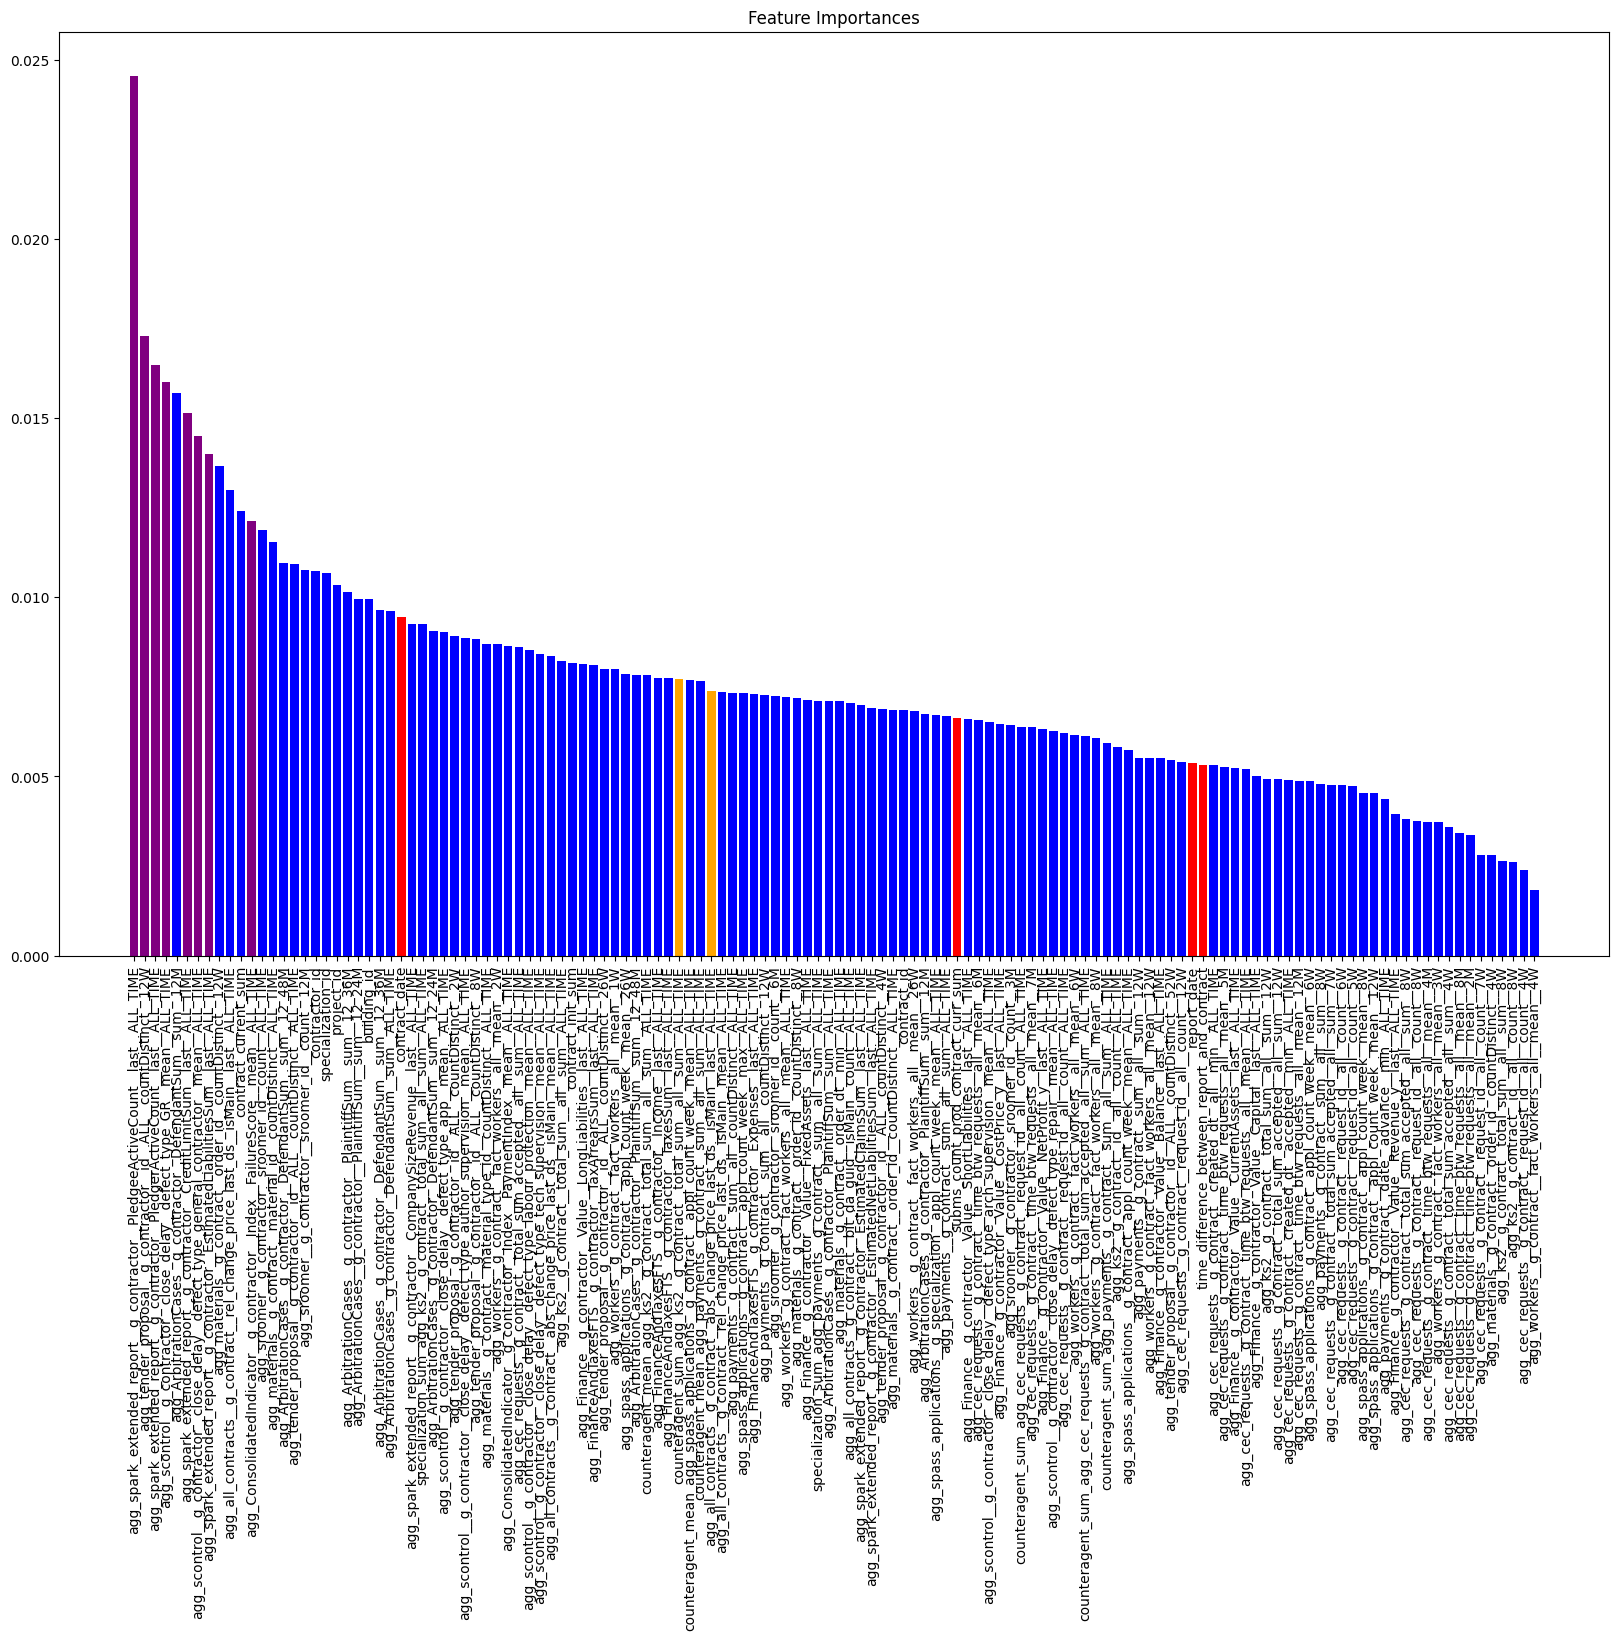

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming Importancies and columns are defined
# Importancies: array of importance values
# columns: array or list of feature names

# Sort the importances in descending order
# indices = np.argsort(Importancies)[::-1]

# # Sort the feature names based on their importance
# sorted_feature_names = columns[indices]
# sorted_importances = Importancies[indices]

# Plot the feature importances
plt.figure(figsize=(20, 12))
plt.title("Feature Importances")

# Iterate over the sorted features and color the "random" feature red
# colors = ['red' if feature in my_features else 'blue' for feature in sorted_feature_names]

plt.bar(range(len(sorted_importances)), sorted_importances, color=colors, align="center")
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)

plt.show()


In [105]:
for i in Importancies_with_columns:
    if i in my_features:
        print(i, Importancies_with_columns[i])

report_date [np.float32(0.005374867)]
contract_date [np.float32(0.009446381)]
subms_count_prod_contract_curr_sum [np.float32(0.0066257543)]
time_difference_between_report_and_contract [np.float32(0.0053254883)]


In [106]:
Importancies_with_columns['agg_ConsolidatedIndicator__g_contractor__Index__FailureScore__mean__ALL_TIME'][0]

np.float32(0.012139544)

In [107]:
for i in Importancies_with_columns:
    if i in Dark_features:
        print(i, Importancies_with_columns[i])

In [108]:
importn = pd.DataFrame(Importancies_with_columns).T.sort_values(by = 0, ascending=False)
for i in importn.index:
    if i == 'contract_current_sum':
        print(importn.loc[i])

0    0.012407
Name: contract_current_sum, dtype: float32


In [111]:
imp = []
for index, value in enumerate(importn[0]):
    if value >= Importancies_with_columns['agg_cec_requests__g_contract__request_id__all__count__5W'][0] and value < Importancies_with_columns['time_difference_between_report_and_contract'][0]:
       imp.append(importn.index[index])
imp

['agg_cec_requests__g_contract__created_dt__all__min__ALL_TIME',
 'agg_cec_requests__g_contract__time_btw_requests__all__mean__5M',
 'agg_Finance__g_contractor__Value__CurrentAssets__last__ALL_TIME',
 'agg_cec_requests__g_contract__time_btw_requests__all__mean__ALL_TIME',
 'agg_Finance__g_contractor__Value__Capital__last__ALL_TIME',
 'agg_ks2__g_contract__total_sum__all__sum__12W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__12W',
 'agg_cec_requests__g_contract__created_dt__accepted__min__ALL_TIME',
 'agg_cec_requests__g_contract__time_btw_requests__all__mean__12M',
 'agg_spass_applications__g_contract__appl_count_week__mean__6W',
 'agg_payments__g_contract__sum__all__sum__8W',
 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__7W',
 'agg_cec_requests__g_contract__request_id__all__count__6W',
 'agg_cec_requests__g_contract__request_id__all__count__5W']

In [215]:
imp = []
for index, value in enumerate(importn[0]):
    if value < 0.0054571806:
       imp.append(importn.index[index])
imp

['Segment_____my_cluster',
 'agg_payments__g_contract__sum__all__sum__ALL_TIME',
 'counteragent_sum_agg_cec_requests__g_contract__total_sum_accepted__all__sum__ALL_TIME',
 'agg_spark_extended_report__g_contractor__EstimatedClaimsSum__last__ALL_TIME',
 'agg_materials__g_contract__order_id__countDistinct__12W',
 'agg_cec_requests__g_contract__time_btw_requests__all__mean__6M',
 'agg_payments__g_contract__sum__all__countDistinct__12W',
 'agg_Finance__g_contractor__Value__Balance__last__ALL_TIME',
 'agg_sroomer__g_contractor__sroomer_id__count__3M',
 'agg_workers__g_contract__fact_workers__all__mean__4W',
 'log_material_defects_rely_on_prod_contr_curr',
 'agg_ks2__g_contract__total_sum__all__sum__12W',
 'agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME',
 'agg_Finance__g_contractor__Value__CostPrice_y__last__ALL_TIME',
 'agg_materials__g_contract__order_id__countDistinct__8W',
 'agg_Finance__g_contractor__Value__Revenue_y__last__ALL_TIME',
 'agg_cec_requests__g_contract_

In [262]:
imp = []
for index, value in enumerate(importn[0]):
    if value < 0.01 and value > 0.004:
       imp.append(importn.index[index])
imp

['agg_scontrol__g_contractor__close_delay__defect_type_general_contractor__mean__ALL_TIME',
 'agg_ConsolidatedIndicator__g_contractor__Index__FailureScore__mean__ALL_TIME',
 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__ALL_TIME',
 'contractor_id',
 'contract_year',
 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_48M',
 'building_id',
 'agg_ConsolidatedIndicator__g_contractor__Index__PaymentIndex__mean__ALL_TIME',
 'project_id',
 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME',
 'defects_with_materials',
 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_36M',
 'agg_spark_extended_report__g_contractor__CompanySizeRevenue__last__ALL_TIME',
 'agg_sroomer__g_contractor__sroomer_id__count__ALL_TIME',
 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_48M',
 'agg_ks2__g_contract__total_sum__all__sum__ALL_TIME',
 'agg_materials__g_contract__material_id__countDistinct__ALL_TIME',
 'agg_ArbitrationCases__g_contractor__Pl

In [263]:
random_imp = Importancies_with_columns['random']
to_del = Importancies[Importancies < random_imp]

KeyError: 'random'

In [78]:
trash_cols = []
for i in Importancies_with_columns:
    if Importancies_with_columns[i] in to_del:
        print(i)
        trash_cols.append(i)

In [79]:
trash_cols

[]

##### Попробуем удалить столбцы, которые ниже порогового значения влияния


In [264]:
trash = []
for i in Importancies_with_columns:
    if Importancies_with_columns[i] in Importancies[Importancies < 0.003]:
        trash.append(i)

In [265]:
trash

['agg_cec_requests__g_contract__request_id__all__count__4W',
 'agg_cec_requests__g_contract__request_id__all__count__7W',
 'agg_cec_requests__g_contract__time_btw_requests__all__mean__2M',
 'agg_ks2__g_contract__id__all__count__8W',
 'agg_ks2__g_contract__total_sum__all__sum__12W',
 'agg_workers__g_contract__fact_workers__all__mean__3W',
 'agg_spark_extended_report__g_contractor__PledgeeActiveCount__last__ALL_TIME',
 'agg_Finance__g_contractor__Value__CostPrice_y__last__ALL_TIME']

## Permutation importancies


In [266]:
from sklearn.inspection import permutation_importance
# Compute permutation importance
perm_importance = permutation_importance(clf, test_X, test_y, n_repeats=10, random_state=42)

# Display importances
for i in perm_importance.importances_mean.argsort()[::-1]:
    if perm_importance.importances_mean[i] - 2 * perm_importance.importances_std[i] > 0:
        print(f"{clf.feature_names_in_[i]:<8} "
              f"{perm_importance.importances_mean[i]:.3f} "
              f" +/- {perm_importance.importances_std[i]:.3f}")

contract_current_sum 0.079  +/- 0.003
contract_id 0.033  +/- 0.004
building_id 0.022  +/- 0.002
project_id 0.018  +/- 0.002
contract_day 0.010  +/- 0.002
contract_init_sum 0.009  +/- 0.001
contractor_id 0.009  +/- 0.002
contract_weekday 0.008  +/- 0.002
report_month 0.008  +/- 0.002
subms_count_prod_contract_curr_sum 0.007  +/- 0.001
specialization_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME 0.007  +/- 0.001
contract_month 0.007  +/- 0.002
specialization_id 0.006  +/- 0.002
specialization_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME 0.006  +/- 0.001
agg_spark_extended_report__g_contractor__CreditLimitSum__last__ALL_TIME 0.005  +/- 0.002
agg_spass_applications__g_specialization__appl_count_week__mean__ALL_TIME 0.005  +/- 0.002
agg_scontrol__g_contractor__close_delay__defect_type_labour_protection__mean__ALL_TIME 0.004  +/- 0.001
agg_ConsolidatedIndicator__g_contractor__Index__Overall__mean__ALL_TIME 0.004  +/- 0.001
agg_spark_extended_report__g_contractor__EstimatedL

In [267]:
# Prepare data for heatmap
importance_scores = []
feature_names = []

for i in perm_importance.importances_mean.argsort()[::-1]:
    if perm_importance.importances_mean[i] - 2 * perm_importance.importances_std[i] > 0:
        importance_scores.append(perm_importance.importances_mean[i])
        feature_names.append(X_train.columns[i])

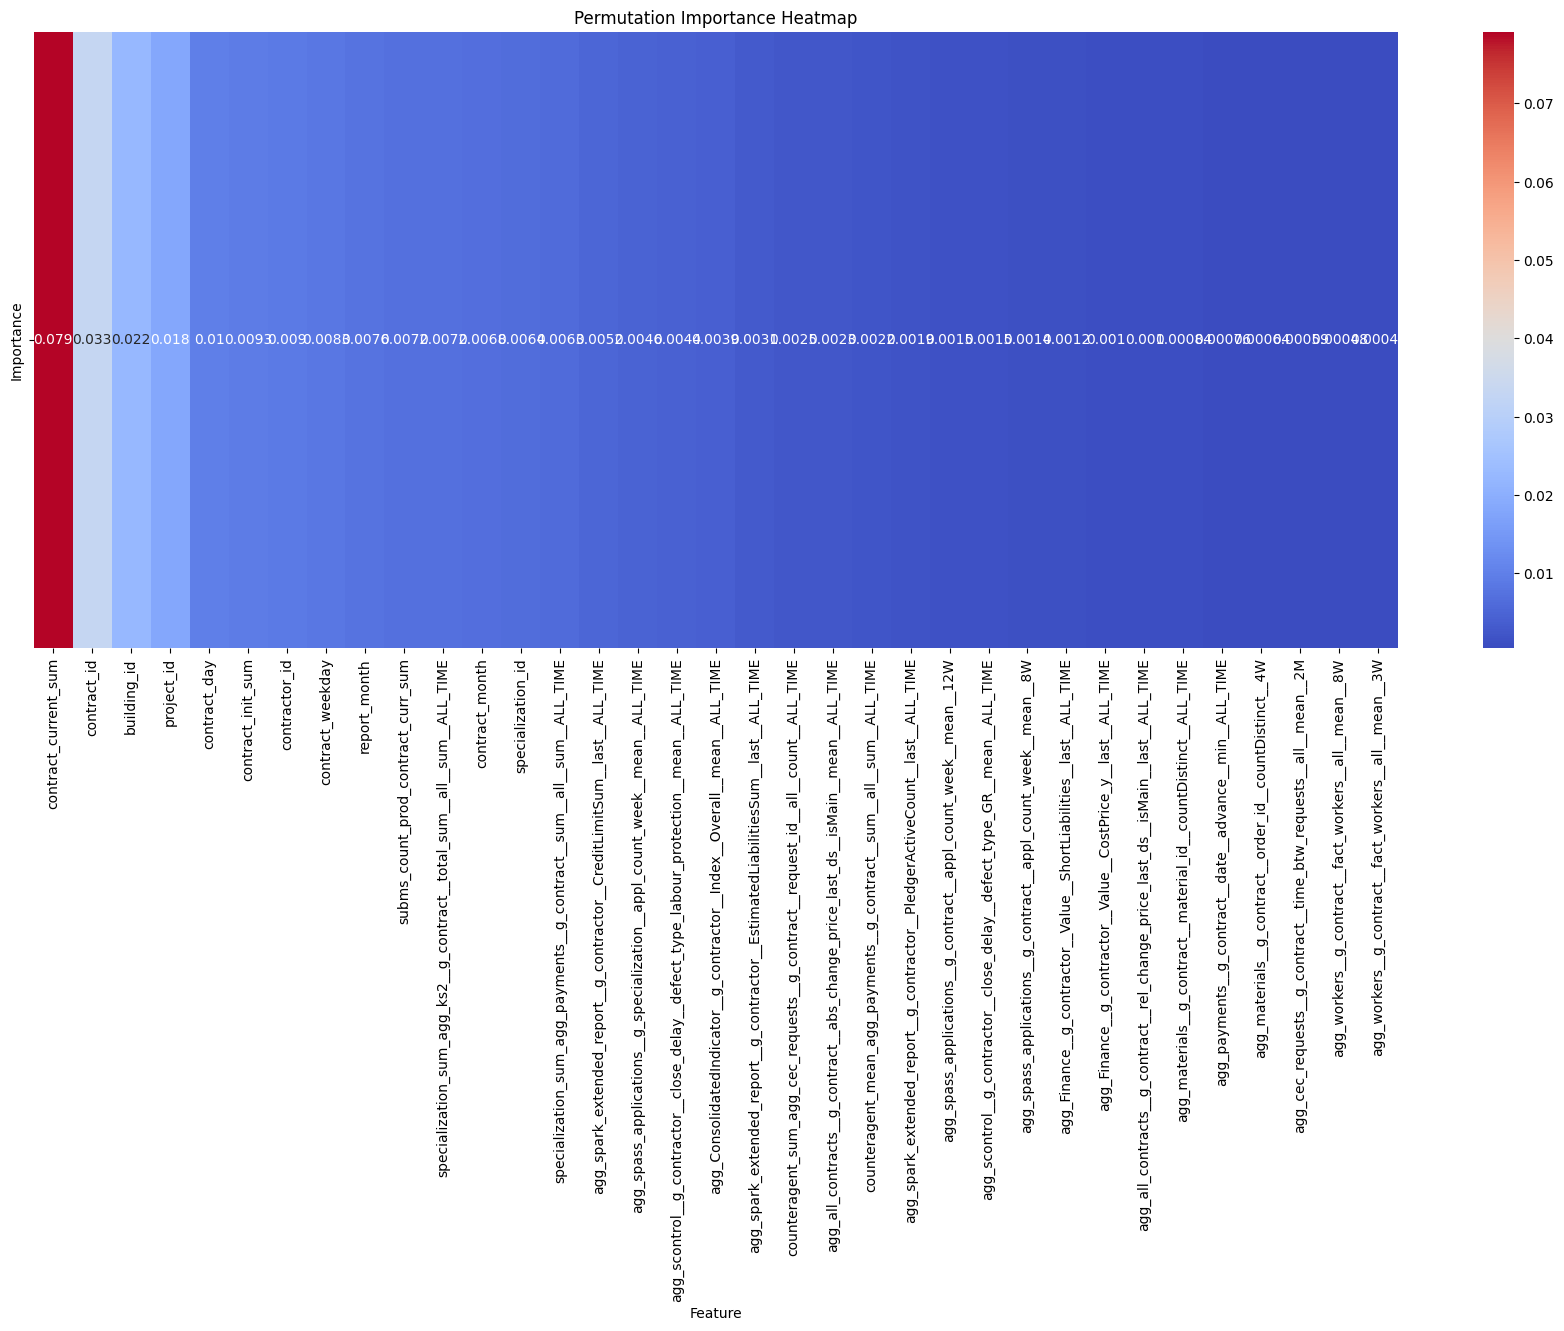

In [268]:
# Create DataFrame for heatmap
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
})
# Set the index to 'Feature' for better plotting
importance_df.set_index('Feature', inplace=True)

# Plot heatmap
plt.figure(figsize=(22, 8))
sns.heatmap(importance_df.T, annot=True, cmap='coolwarm', cbar=True)
plt.title('Permutation Importance Heatmap')
plt.show()

In [269]:
s = 0
for i in perm_importance.importances_mean.argsort()[::-1]:
    if perm_importance.importances_mean[i] - 2 * perm_importance.importances_std[i] > 0:
        if X_train.columns[i] in my_features:
            print(f"{X_train.columns[i]:<8} "
                  f"{perm_importance.importances_mean[i]:.3f} "
                  f" +/- {perm_importance.importances_std[i]:.3f}")
            s += 1

subms_count_prod_contract_curr_sum 0.007  +/- 0.001
